In [153]:
!pip install transformers
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install easyocr
!sudo apt-get install -y poppler-utils
!pip install pdf2image
!pip install cv
!pip install opencv-python
!pip install opencv-python-headless


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.6).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [154]:
!wget "https://fonts.googleapis.com/css2?family=Roboto:wght@700" -O roboto-bold.css
!wget -O Roboto-Bold.ttf $(grep -o "https://[^']*\.ttf" roboto-bold.css | sed 's/\\//g')

--2025-02-23 23:31:54--  https://fonts.googleapis.com/css2?family=Roboto:wght@700
Resolving fonts.googleapis.com (fonts.googleapis.com)... 74.125.202.95, 2607:f8b0:4001:c00::5f
Connecting to fonts.googleapis.com (fonts.googleapis.com)|74.125.202.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/css]
Saving to: ‘roboto-bold.css’

roboto-bold.css         [ <=>                ]     234  --.-KB/s    in 0s      

2025-02-23 23:31:54 (72.0 MB/s) - ‘roboto-bold.css’ saved [234]

--2025-02-23 23:31:54--  https://fonts.gstatic.com/s/roboto/v47/KFOMCnqEu92Fr1ME7kSn66aGLdTylUAMQXC89YmC2DPNWuYjammT.ttf
Resolving fonts.gstatic.com (fonts.gstatic.com)... 142.251.183.94, 2607:f8b0:4001:c1d::5e
Connecting to fonts.gstatic.com (fonts.gstatic.com)|142.251.183.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113364 (111K) [font/ttf]
Saving to: ‘Roboto-Bold.ttf’

Roboto-Bold.ttf     100%[===================>] 110.71K  --.-KB/s    in 

In [155]:

from transformers import AutoImageProcessor, TableTransformerForObjectDetection
import torch
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd
from pdf2image import convert_from_path
from tqdm.auto import tqdm
import pytesseract
import easyocr
import cv2
import numpy as np
import re



In [180]:
# copy the path of the pdf to be tested below
def pdf_to_img(image_path):

  image = convert_from_path(pdf_path)[0].convert("RGB")
  return image

pdf_path = 'test1.pdf'
image = pdf_to_img(pdf_path)


In [181]:

model_name = "microsoft/table-transformer-detection"
# define image preprocessor for table transformer
image_processor = AutoImageProcessor.from_pretrained(model_name)

# import table transformer model for table detection
model = TableTransformerForObjectDetection.from_pretrained(model_name,
                                                           revision="no_timm")


In [182]:

def detect_table(image_doc):

  # preproces image document
  inputs = image_processor(images = image_doc, return_tensors="pt")

  # detect tables
  outputs = model(**inputs)

  # convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
  target_sizes = torch.tensor([image_doc.size[::-1]])
  results = image_processor.post_process_object_detection(outputs,
                                                          threshold=0.9,
                                                          target_sizes=target_sizes)[0]

  return results


results = detect_table(image)
results


{'scores': tensor([0.9996], grad_fn=<IndexBackward0>),
 'labels': tensor([0]),
 'boxes': tensor([[ 213.3967, 1206.3638, 1455.4703, 1956.2015]],
        grad_fn=<IndexBackward0>)}

In [183]:

def get_table_bbox(results):

  tables_coordinates = []

  # iterate through all the detected table data
  for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]

    # store bbox coodinates in Pascal VOC format for later use
    table_dict = {"xmin" : box[0],
                  "ymin" : box[1],
                  "xmax" : box[2],
                  "ymax" : box[3]}

    tables_coordinates.append(table_dict)

    # print prediction label, prediction confidence score, and bbox values
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
        )

  return tables_coordinates

table_bbox = get_table_bbox(results)


Detected table with confidence 1.0 at location [213.4, 1206.36, 1455.47, 1956.2]


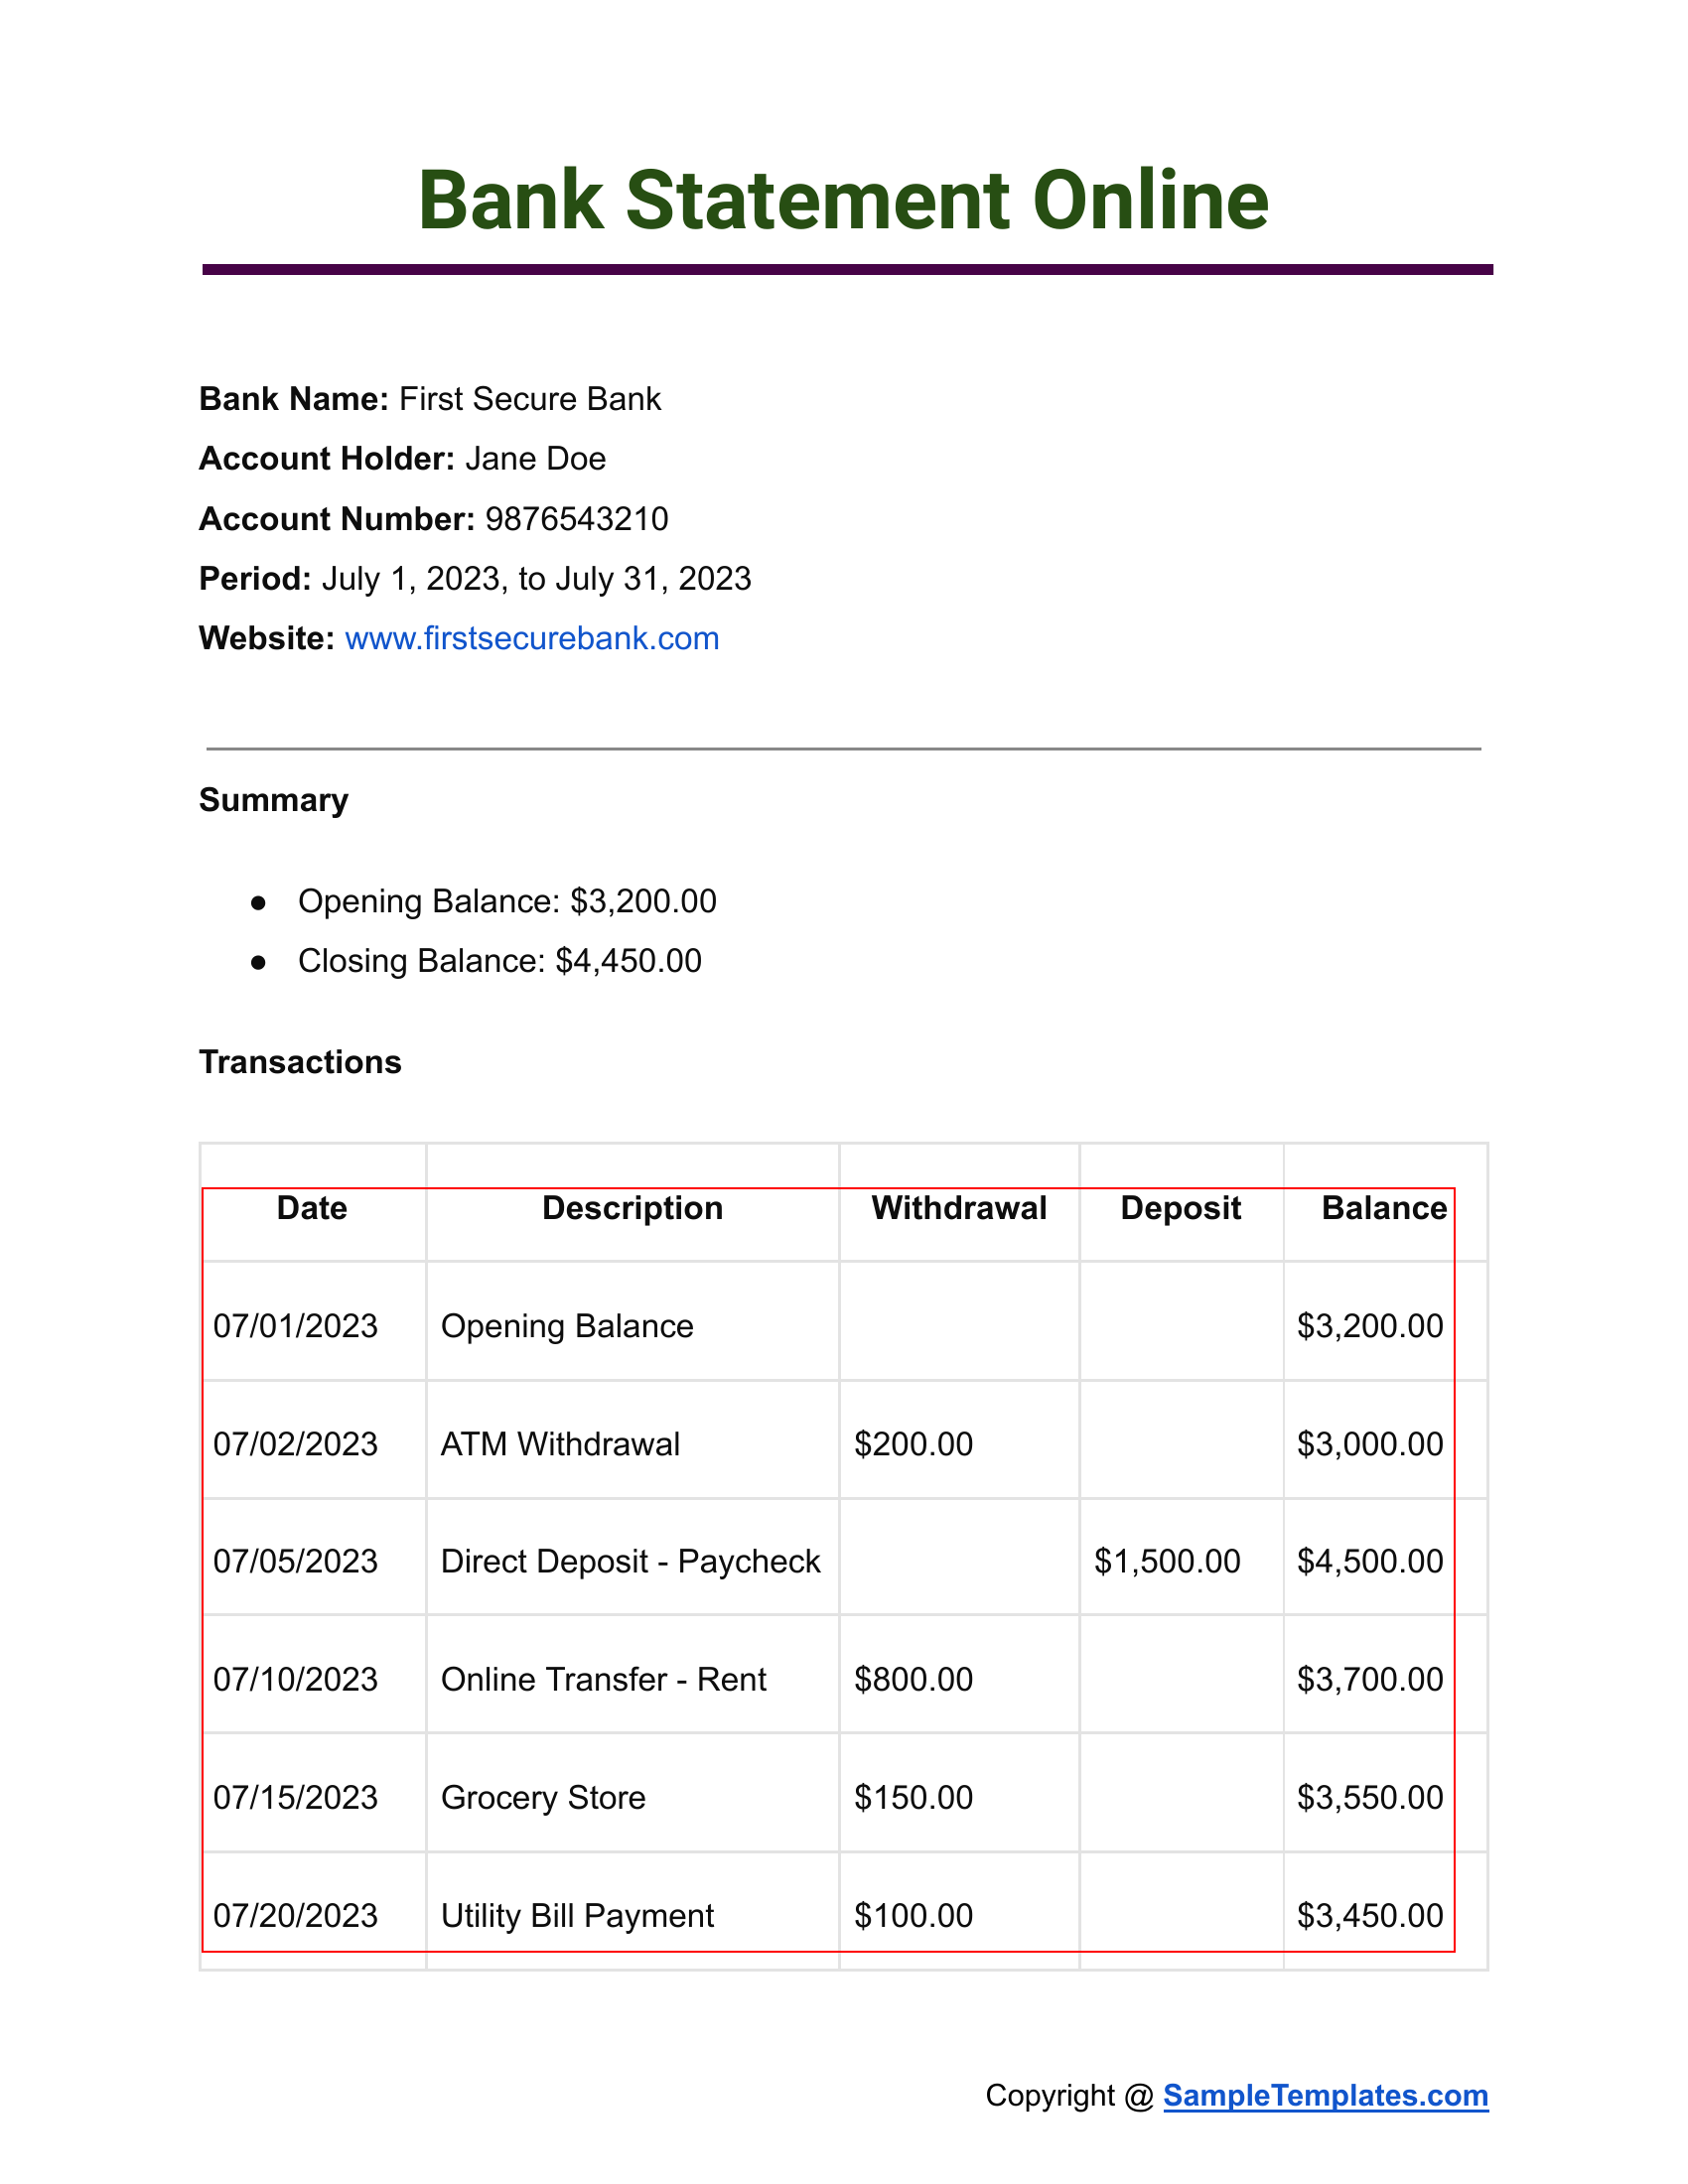

In [184]:

def highlight_tables(image, table_bbox, padding):
    # Create a drawing context for doc image
    doc_image = image.copy()
    draw = ImageDraw.Draw(doc_image)

    # Iterate over each table in the list
    for table in table_bbox:
        # Define the coordinates for the rectangle with padding for each table
        rectangle_coords = (table["xmin"] - padding,
                            table["ymin"] - padding,
                            table["xmax"] + padding,
                            table["ymax"] + padding)

        # Draw a red rectangle around the detected table
        draw.rectangle(rectangle_coords, outline="red", width=2)

    return doc_image

padding = 10
table_detected_image = highlight_tables(image, table_bbox, padding)
table_detected_image


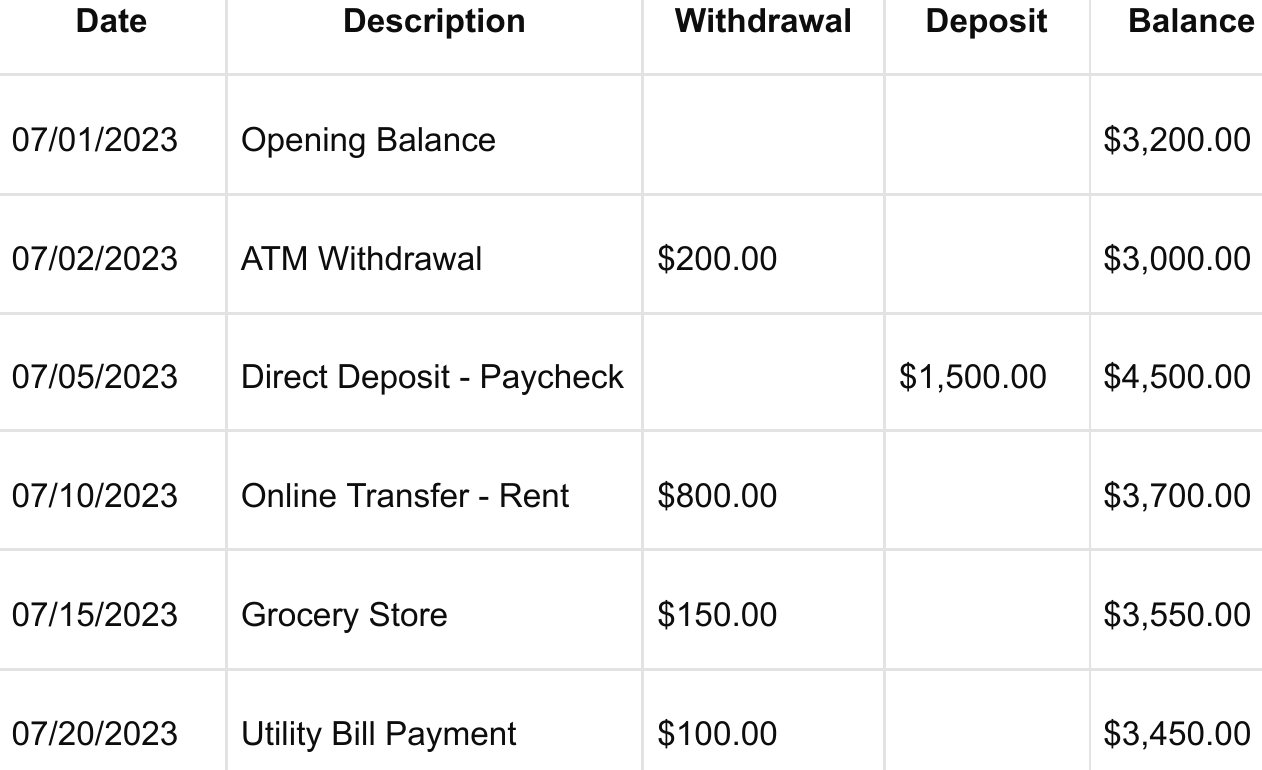

In [185]:
def get_cropped_image(image, table, padding):
  # Create a new image object with the cropped area
  cropped_image = image.copy().crop((table["xmin"] -padding,
                             table["ymin"] - padding,
                             table["xmax"] + padding,
                             table["ymax"] + padding
                             ))

  return cropped_image

cropped_image = get_cropped_image(image, table_bbox[0], padding)
cropped_image


In [186]:

# import model for detecting table features e.g. rows, columns, etc
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")


In [187]:

def get_table_features(cropped_image):

  # preprocess image input for table transformer
  inputs = image_processor(images = cropped_image, return_tensors="pt")

  # make prediction using table transformer
  outputs = structure_model(**inputs)

  # post process output to Pasval VOC bbox format
  target_sizes = torch.tensor([cropped_image.size[::-1]])
  results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]

  # define a list to store detected features
  features = []

  # iterate through all the detected features and store feature label, confidence score, and bbox values to cells list
  for i, (score, label, box) in enumerate(zip(results["scores"], results["labels"], results["boxes"])):
      box = [round(i, 2) for i in box.tolist()]
      score = score.item()
      label = structure_model.config.id2label[label.item()]

      cell_dict = {"label":label,
                  "score":score,
                  "bbox":box
                  }


      # print table features
      features.append(cell_dict)
      print(
          f"Detected {label} with confidence "
          f"{round(score, 3)} at location {box}"
      )

  return features


features = get_table_features(cropped_image)


Detected table column with confidence 1.0 at location [209.47, 2.72, 640.78, 751.61]
Detected table column with confidence 1.0 at location [876.75, 2.42, 1077.47, 751.64]
Detected table column with confidence 1.0 at location [639.61, 2.39, 875.97, 751.54]
Detected table row with confidence 1.0 at location [8.75, 78.3, 1256.84, 199.93]
Detected table column with confidence 1.0 at location [1077.38, 2.6, 1257.05, 751.65]
Detected table column header with confidence 0.999 at location [8.68, 2.36, 1256.76, 77.98]
Detected table row with confidence 0.999 at location [8.46, 200.03, 1256.98, 317.73]
Detected table row with confidence 1.0 at location [8.48, 553.73, 1256.94, 673.19]
Detected table row with confidence 1.0 at location [8.61, 316.75, 1256.78, 436.0]
Detected table with confidence 1.0 at location [8.49, 2.52, 1256.81, 751.75]
Detected table row with confidence 1.0 at location [8.52, 672.93, 1256.73, 751.9]
Detected table column with confidence 1.0 at location [8.35, 2.45, 208.44, 7

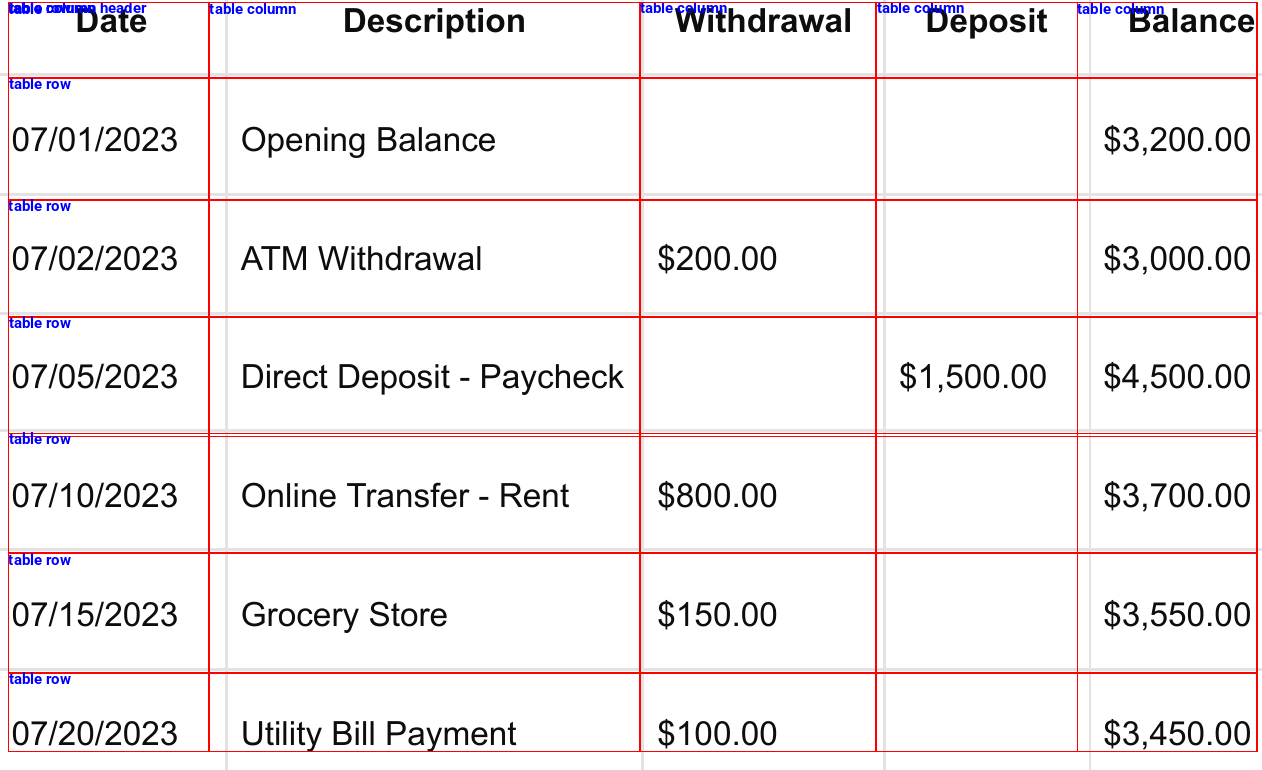

In [188]:

def display_detected_features(cropped_image, features):

  cropped_table_visualized = cropped_image.copy()
  draw = ImageDraw.Draw(cropped_table_visualized)

  # increase font size for text labels
  font = ImageFont.truetype("Roboto-Bold.ttf", 15)

  # iterate through all features and display bounding box with text labels
  for feature in features:
      draw.rectangle(feature["bbox"], outline="red")

      text_position = (feature["bbox"][0], feature["bbox"][1] - 3)

      draw.text(text_position, feature["label"], fill="blue", font = font)

  # return cropped image with bounding box
  return cropped_table_visualized

display_detected_features(cropped_image, features)


In [189]:
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']

    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x['bbox'][1])
    columns.sort(key=lambda x: x['bbox'][0])

    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
        return cell_bbox

    # Generate cell coordinates and count cells in each row
    cell_coordinates = []

    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({'cell': cell_bbox})

        # Append row information to cell_coordinates
        cell_coordinates.append({'cells': row_cells, 'cell_count': len(row_cells)})


    return cell_coordinates

cell_coordinates = get_cell_coordinates_by_row(features)


In [190]:
def apply_ocr(cell_coordinates, cropped_image):
    data = {}
    reader = easyocr.Reader(['en'])  # Initialize EasyOCR

    for idx, row in enumerate(tqdm(cell_coordinates)):
        row_text = []
        for cell in row["cells"]:
            # Crop cell with expanded boundaries
            cell_img = cropped_image.crop((
                cell["cell"][0]-3,
                cell["cell"][1]-3,
                cell["cell"][2]+3,
                cell["cell"][3]+3
            ))

            # OpenCV preprocessing
            cv_img = cv2.cvtColor(np.array(cell_img), cv2.COLOR_RGB2BGR)
            gray = cv2.cvtColor(cv_img, cv2.COLOR_BGR2GRAY)
            thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]

            # Check for empty cells using pixel density
            if np.mean(thresh) < 5.0:  # Empty cell threshold
                row_text.append('')
                continue

            # OCR with dual validation
            tesseract_text = pytesseract.image_to_string(
                thresh,
                config='--psm 6 -c tessedit_char_whitelist=0123456789$,.ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz/ '
            ).strip()

            easyocr_text = reader.readtext(thresh, detail=0)
            combined_text = ' '.join(easyocr_text).strip()

            # Text consensus
            final_text = combined_text if len(combined_text) > len(tesseract_text) else tesseract_text

            # # Post-processing
            # final_text = final_text.replace('O', '0').replace('o', '0').replace('B', '8')
            # if any(c.isalpha() for c in final_text) and '$' not in final_text:
            #     final_text = final_text.replace('$', '')
            # Inside the post-processing block

            row_text.append(final_text)

        # Column alignment fix
        expected_columns = 5
        if idx == 0:  # Header validation
            headers = [txt.lower() for txt in row_text]
            if 'date' not in headers[0]:
                row_text = ['Date', 'Description', 'Withdrawal', 'Deposit', 'Balance']
        else:
            # Numeric field validation
            for i in [2, 3, 4]:  # Withdrawal, Deposit, Balance columns
                if i < len(row_text):
                    row_text[i] = ''.join([c for c in row_text[i] if c in '0123456789.,$'])
                    if row_text[i].count('.') > 1:
                        row_text[i] = row_text[i].replace('.', '', row_text[i].count('.')-1)

        # Force 5-column structure
        row_text = row_text[:expected_columns] + ['']*(expected_columns - len(row_text))
        data[idx] = row_text

    return data

In [191]:

def write_csv(data):
    with open('output.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        # Write header based on first row
        header = ['Date', 'Details', 'Withdrawals', 'Deposits', 'Balance']
        writer.writerow(header)

        # Write data rows
        for idx in sorted(data.keys()):
            if idx == 0: continue  # Skip original header
            row = data[idx]

            # Post-processing for known patterns
            if len(row) >= 2 and 'payment' in row[1].lower():
                row[1] = 'Bill payment'
            if len(row) >= 1 and 'apr' in row[0].lower():
                row[0] = row[0].upper().replace('AOR', 'Apr')

            writer.writerow(row[:5])  # Ensure exactly 5 columns



In [192]:
cell_coordinates = get_cell_coordinates_by_row(features)


In [193]:
data = apply_ocr(cell_coordinates, cropped_image)


  0%|          | 0/7 [00:00<?, ?it/s]

In [194]:
write_csv(data)


In [195]:
# 4. Verify results
df = pd.read_csv("output.csv")
print("Final extracted table:")
print(df)

Final extracted table:
         Date                  Details Withdrawals   Deposits    Balance
0  07/01/2023          Opening Balance         NaN        NaN  $3,200.00
1  07/02/2023           ATM Withdrawal     $200.00        NaN  $3,000.00
2  07/05/2023  Direct Deposit Paycheck         NaN  $1,500.00  $4,500.00
3  07/10/2023     Online Transfer Rent     $800.00        NaN  $3,700.00
4  07/15/2023            Grocery Store     $150.00        NaN  $3,550.00
5  07/20/2023             Bill payment     $100.00        NaN  $3,450.00
